# **FLIGHT DELAY PREDICTION USING WEATHER API**

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('fin.csv')

# Encode categorical variables
data = pd.get_dummies(data, columns=['weather_description', 'wind'])

# Handle missing values if any (optional)
data = data.dropna()

# Check the first few rows of the preprocessed data
print(data.head())


In [ ]:
import pandas as pd

# Load your dataset from a CSV file
# Replace 'your_dataset.csv' with the actual file path
data = pd.read_csv('fin.csv')
# Calculate weather feature differences between departure and destination
data['temp_difference'] = data.groupby('source_place')['temperature_at_source'].transform(lambda x: x.diff())
data['humidity_difference'] = data.groupby('source_place')['humidity_at_source'].transform(lambda x: x.diff())
data['wind_speed_difference'] = data.groupby('source_place')['wind_speed'].transform(lambda x: x.diff())

# Encode wind direction as numerical values (e.g., N: 0, NW: 45, etc.)
wind_direction_mapping = {'N': 0, 'NW': 45, 'W': 90, 'SW': 135, 'S': 180, 'SE': 225, 'E': 270, 'NE': 315}
data['departure_wind_direction_deg'] = data['wind'].map(wind_direction_mapping)
data['destination_wind_direction_deg'] = data['wind'].map(wind_direction_mapping)
data['wind_direction_difference'] = data['departure_wind_direction_deg'] - data['destination_wind_direction_deg']

# You can include additional features like year, month, and location differences

# Print the updated DataFrame
print(data)


# You can include additional features like year, month, and location differences



      source_place weather_description  latitude_of_source  \
0          Chicago               Rainy             41.8781   
1          Chicago               Sunny             41.8781   
2      San Antonio               Sunny             29.4241   
3      Los Angeles              Cloudy             34.0522   
4          Houston       Partly cloudy             29.7604   
...            ...                 ...                 ...   
1045   Los Angeles       Partly cloudy             34.0522   
1046      New York               Sunny             40.7128   
1047      San Jose              Cloudy             37.3382   
1048     San Diego               Snowy             32.7157   
1049  Philadelphia       Partly cloudy             39.9526   

      longitude_of_source  temperature_at_source  humidity_at_source wind  \
0                -87.6298                    1.3                13.5    N   
1                -87.6298                   27.7                 7.1   NW   
2                -98.493

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your predefined dataset (historical data)
# Replace 'your_dataset.csv' with the actual file path


# Drop rows with missing values in both X and y
data.dropna(subset=['temp_difference', 'humidity_difference', 'wind_speed_difference', 'wind_direction_difference', 'flight_delay'], inplace=True)

# Define the features (X) and the target variable (y)
X = data[['temp_difference', 'humidity_difference', 'wind_speed_difference', 'wind_direction_difference']]
y = data['flight_delay']

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a regression model (Random Forest in this example)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Mean Absolute Error: 0.5000961538461538
Mean Squared Error: 0.28683942307692306


In [ ]:
import joblib

# Assuming 'model' is your trained model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model to a file
joblib.dump(model, 'flight_delay_model.pkl')


['flight_delay_model.pkl']

In [ ]:
import requests
import joblib
from datetime import datetime

# OpenWeatherMap API key (replace with your actual API key)
api_key = 'bea2d5f59fbe00679f07d0e83e50e498'

# Location mapping from location code to location name
location_mapping = {
    'NYC': 'New York',
    'LA': 'Los Angeles',
    'CHI': 'Chicago',
    'HOU': 'Houston',
    'PHX': 'Phoenix',
    'PHI': 'Philadelphia',
    'SAT': 'San Antonio',
    'SD': 'San Diego',
    'DAL': 'Dallas',
    'SJ': 'San Jose'
}

# Function to get location code from location name
def get_location_code(location_name):
    for code, name in location_mapping.items():
        if name.lower() == location_name.lower():
            return code
    return None

# Function to get weather data for a specific date and location using OpenWeatherMap API
def get_weather_data(location_name, date):
    base_url = 'https://api.openweathermap.org/data/2.5/forecast'
    params = {
        'q': location_name,
        'appid': api_key,
        'units': 'imperial',  # For Fahrenheit units
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()

        # Find the weather data for the specific date (dd/mm/yyyy)
        target_date = datetime.strptime(date, '%d/%m/%Y').date()

        for forecast in data['list']:
            forecast_date = datetime.fromtimestamp(forecast['dt']).date()
            if forecast_date == target_date:
                return forecast

        return None  # Date not found in the data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None

# Load the trained model from a saved file
model = joblib.load('flight_delay_model.pkl')  # Replace with the actual model file path

# Create a function to predict flight delay based on real-time weather data
def predict_flight_delay(departure_name, destination_name, date):
    # Get location codes from location names
    departure_code = get_location_code(departure_name)
    destination_code = get_location_code(destination_name)

    # Fetch weather data for departure and destination on the specified date
    departure_weather = get_weather_data(departure_name, date)
    destination_weather = get_weather_data(destination_name, date)

    if departure_weather and destination_weather:
        # Calculate feature differences based on real-time weather data
        temperature = destination_weather['main']['temp']
        humidity = destination_weather['main']['humidity']
        wind_speed = destination_weather['wind']['speed']
        wind_direction = destination_weather['wind'].get('deg', 0.0)  # Default to 0 if not available

        reference_temperature = departure_weather['main']['temp']
        reference_humidity = departure_weather['main']['humidity']
        reference_wind_speed = departure_weather['wind']['speed']
        reference_wind_direction = departure_weather['wind'].get('deg', 0.0)

        # Create a DataFrame with the input data
        data = pd.DataFrame({
            'temp_difference': [temperature - reference_temperature],  # Calculate temperature difference
            'humidity_difference': [humidity - reference_humidity],     # Calculate humidity difference
            'wind_speed_difference': [wind_speed - reference_wind_speed],  # Calculate wind speed difference
            'wind_direction_difference': [wind_direction - reference_wind_direction]  # Calculate wind direction difference
        })

        # Use the trained model to make predictions (1 for delay, 0 for no delay)
        predicted_delay = model.predict(data)

        return predicted_delay, departure_weather, destination_weather
    else:
        return None, None, None

# User input for departure location, destination location, and date
departure_name = input("Enter the departure location name (e.g., New York): ")
destination_name = input("Enter the destination location name (e.g., Los Angeles): ")
date = input("Enter the date (dd/mm/yyyy): ")

# Make a prediction and get weather details
predicted_delay, departure_weather, destination_weather = predict_flight_delay(departure_name, destination_name, date)

if predicted_delay is not None:
    print(f"Predicted Flight Delay (1 for delay, 0 for no delay): {int(predicted_delay[0])}")
    if departure_weather and destination_weather:
        print("Weather Details:")
        print(f"Weather in {departure_name} on {date}:")
        print(f"Temperature: {departure_weather['main']['temp']}°F")
        print(f"Humidity: {departure_weather['main']['humidity']}%")
        print(f"Wind Speed: {departure_weather['wind']['speed']} mph")
        print(f"Wind Direction: {departure_weather['wind'].get('deg', 'N/A')}°")

        print(f"Weather in {destination_name} on {date}:")
        print(f"Temperature: {destination_weather['main']['temp']}°F")
        print(f"Humidity: {destination_weather['main']['humidity']}%")
        print(f"Wind Speed: {destination_weather['wind']['speed']} mph")
        print(f"Wind Direction: {destination_weather['wind'].get('deg', 'N/A')}°")
    else:
        print("Weather information not available for one or more locations.")
else:
    print("Flight delay prediction not available due to missing weather data.")


Enter the departure location name (e.g., New York): New York
Enter the destination location name (e.g., Los Angeles): Los Angeles
Enter the date (dd/mm/yyyy): 15/10/2023
Predicted Flight Delay (1 for delay, 0 for no delay): 0
Weather Details:
Weather in New York on 15/10/2023:
Temperature: 50.67°F
Humidity: 90%
Wind Speed: 10.36 mph
Wind Direction: 42°
Weather in Los Angeles on 15/10/2023:
Temperature: 74.73°F
Humidity: 42%
Wind Speed: 9.42 mph
Wind Direction: 241°


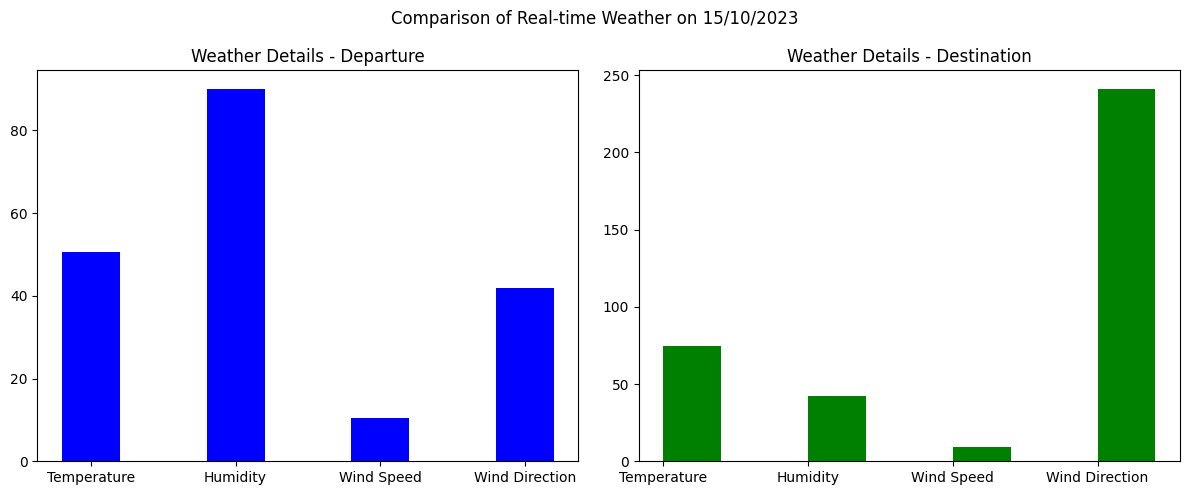

In [ ]:
import matplotlib.pyplot as plt

# Ensure you have fetched 'departure_weather' and 'destination_weather' before this point

if departure_weather and destination_weather:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Weather details for departure location
    departure_temperature = departure_weather['main']['temp']
    departure_humidity = departure_weather['main']['humidity']
    departure_wind_speed = departure_weather['wind']['speed']
    departure_wind_direction = departure_weather['wind'].get('deg', 'N/A')

    # Weather details for destination location
    destination_temperature = destination_weather['main']['temp']
    destination_humidity = destination_weather['main']['humidity']
    destination_wind_speed = destination_weather['wind']['speed']
    destination_wind_direction = destination_weather['wind'].get('deg', 'N/A')

    # Labels for the locations
    labels = ['Temperature', 'Humidity', 'Wind Speed', 'Wind Direction']

    # Values for the departure and destination locations
    departure_values = [departure_temperature, departure_humidity, departure_wind_speed, departure_wind_direction]
    destination_values = [destination_temperature, destination_humidity, destination_wind_speed, destination_wind_direction]

    x = range(len(labels))

    # Plotting the weather details
    ax1.bar(x, departure_values, width=0.4, label='Departure', color='b', align='center')
    ax2.bar(x, destination_values, width=0.4, label='Destination', color='g', align='edge')

    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)

    ax1.set_title('Weather Details - Departure')
    ax2.set_title('Weather Details - Destination')

    plt.suptitle(f'Comparison of Real-time Weather on {date}')
    plt.tight_layout()
    plt.show()
else:
    print("Weather information not available for one or more locations.")
